# Прогнозирование оттока пользователей фитнес-центра

## Оглавление:
* [1. Введение. Описание и цель проекта](#first-bullet)

* [2. Подготовка данных](#second-bullet)
   
* [3. Исследовательский анализ данных](#3-bullet)

* [4. Модель прогнозирования оттока пользователей](#4-bullet)

* [5. Кластеризация пользователей](#5-bullet)
  
* [6. Выводы и рекомендации](#6-bullet)

## 1. Введение. Описание и цель проекта<a class="anchor" id="first-bullet"></a>

<p style="text-indent: 25px;"> Сеть фитнес-центров разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. С этой целью в электронный вид переведены анкеты пользователей. Основная цель исследования — на основании имеющихся анкет провести анализ и подготовить план действий по удержанию клиентов.<p/>

<p style="text-indent: 25px;"> В рамках анализа планируется:<p/>

   - научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
   
   - сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их     основные свойства;
   
   - проанализировать основные признаки, наиболее сильно влияющие на отток;
   
   - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
   
         1) выделить целевые группы клиентов;
         2) предложить меры по снижению оттока;
         3) определить другие особенности взаимодействия с клиентами.

## 2. Подготовка данных<a class="anchor" id="3-bullet"></a>

<p style="text-indent: 25px;">Входные данные представлены в виде csv-файла, содержащего информацию о пользователях на месяц до оттока и факт оттока на определённый месяц.  Анализ будет проводится посредством средств языка Python с использованием сопутствующих библиотек.<p\>
<p style="text-indent: 25px;">Далее представлена более подробная информация о входных данных.<p>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# предустановка общих параметров графиков
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (15, 5)

# вывод предупреждений подавлен
import warnings
warnings.filterwarnings("ignore")

In [3]:
gch = pd.read_csv('/datasets/gym_churn.csv')

In [4]:
#функция агрегирования нужной информации о датасете. Реализовано с целью улучшения визуализации информации.
def intro_df(df_name):

    entries_count = pd.DataFrame(df_name.nunique())
    entries_count.columns = ['values_counts']

    columns_types = pd.DataFrame(df_name.dtypes)
    columns_types.columns = ['dtypes']
    columns_types

    entries_count_isnull = pd.DataFrame(df_name.isnull().sum())
    entries_count_isnull.columns = ['isnull_counts']
    entries_count_isnull
    
    entries_max = pd.DataFrame(df_name.max())
    entries_max.columns = ['max']
    entries_max
    
    entries_min = pd.DataFrame(df_name.min())
    entries_min.columns = ['min']
    
    df_name_intro_info = entries_count.join(columns_types)\
                                      .join(entries_count_isnull)\
                                      .join(entries_max)\
                                      .join(entries_min)
    
    df_name.columns = df_name.columns.str.lower().str.replace(' ','_')

    print('Параметры таблицы , (строк, полей):', df_name.shape)
    print('Количество дубликатов:', df_name.duplicated().sum())
    display(df_name_intro_info.transpose())
    print('Первые 3 строки таблицы:')
    display(df_name.head(3))

    Датасет содержит информацию на месяц до оттока и факт оттока на определённый месяц. 
    Набор данных включает следующие поля:

*Данные пользователя за предыдущий до проверки факта оттока месяц:*
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

*Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:*

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
- 'Churn' — факт оттока в текущем месяце.

In [5]:
intro_df(gch)

Параметры таблицы , (строк, полей): (4000, 14)
Количество дубликатов: 0


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
values_counts,2,2,2,2,2,3,2,23,4000,12,29,3913,3820,2
dtypes,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,float64,int64
isnull_counts,0,0,0,0,0,0,0,0,0,0,0,0,0,0
max,1,1,1,1,1,12,1,41,552.591,12,31,6.02367,6.14678,1
min,0,0,0,0,0,1,0,18,0.148205,1,0,0,0,0


Первые 3 строки таблицы:


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0


<p style="text-indent: 25px;">Оценка датасета показывает, что в нём отсутствуют пропущенные значения и дубликаты. Выборка состоит из данных 4k анкет. Данное количество является достаточным для выполнения целей исследования.<p\>

## 3. Исследовательский анализ данных<a class="anchor" id="3-bullet"></a>

In [6]:
# оценка средних значений и стандартных отклонений признаков
gch.describe()[1:3]

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521


In [7]:
# оценка средних значений признаков по целевой переменной (оттоку)
gch.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


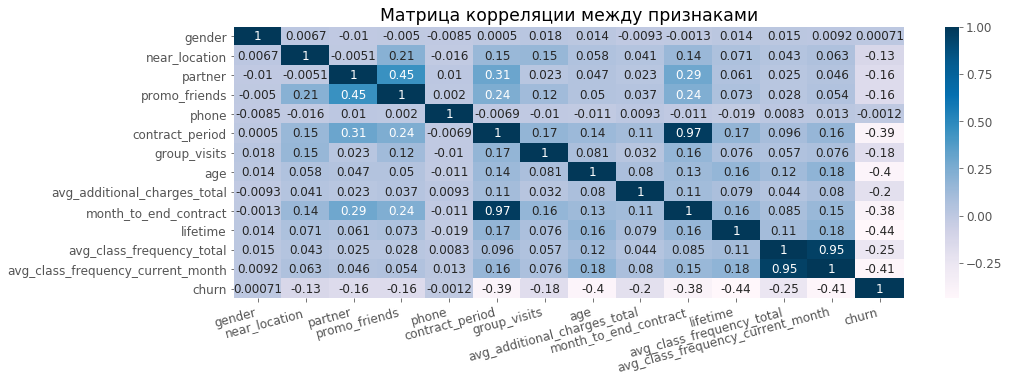

In [8]:
sns.heatmap(gch.corr(), annot=True, cmap="PuBu")
plt.title('Матрица корреляции между признаками')
plt.xticks(rotation=15, ha='right')
plt.show()

In [9]:
# выделение столбцов с категориальными и количественными признаками по количеству уникальных значений

list_q = [] # список полей с количественными переменными
list_c = [] # список полей с категориальными переменными

for col in gch.columns: 
    if gch[col].nunique() > 2: list_q.append(col)
    else: list_c.append(col)
        
# удаление 'churn' как бессмысленного к построению
list_c.pop();

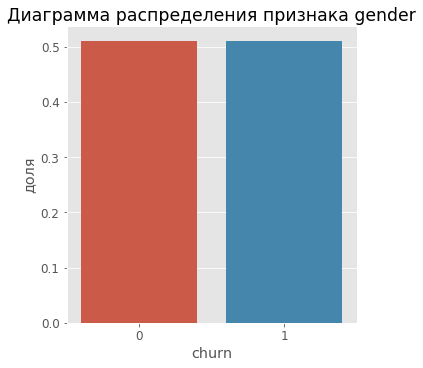

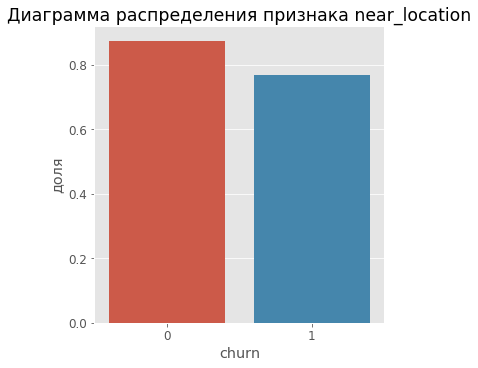

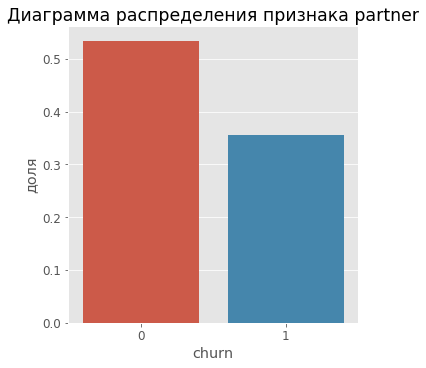

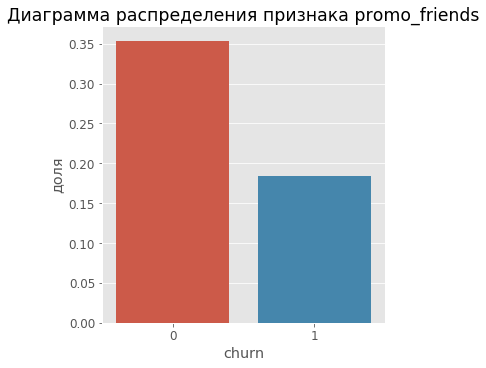

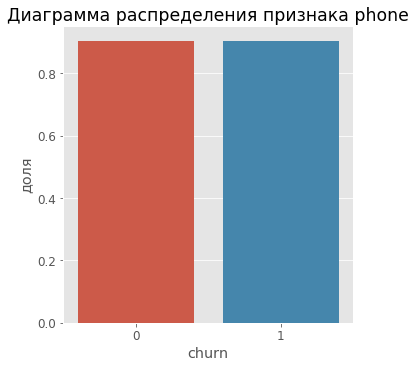

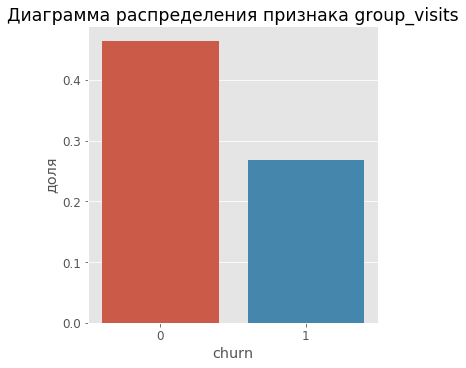

In [10]:
# построение диаграмм распределения категориальных признаков по целевой переменной (оттоку)

for col in list_c:
    sns.catplot(y=col, x="churn", data=gch, kind='bar', ci=0)
    plt.title('Диаграмма распределения признака {}'.format(col))
    plt.ylabel('доля')

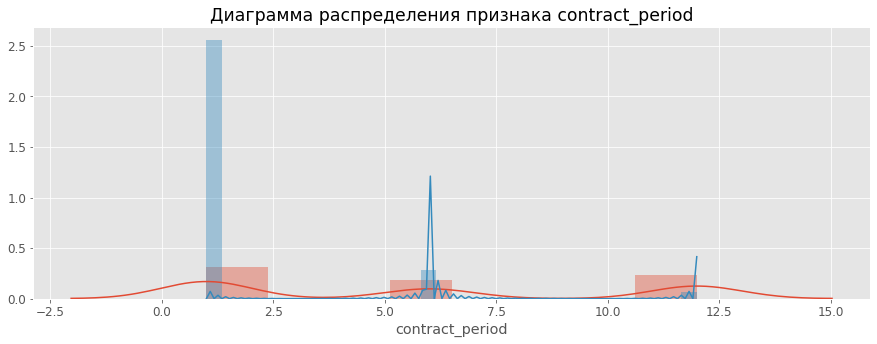

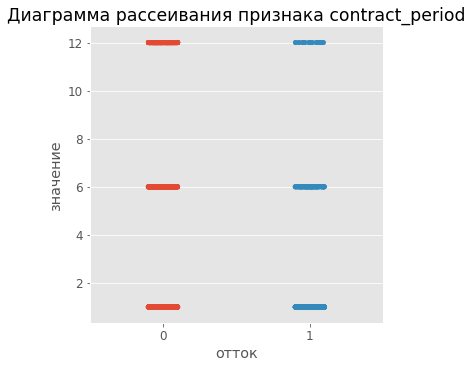

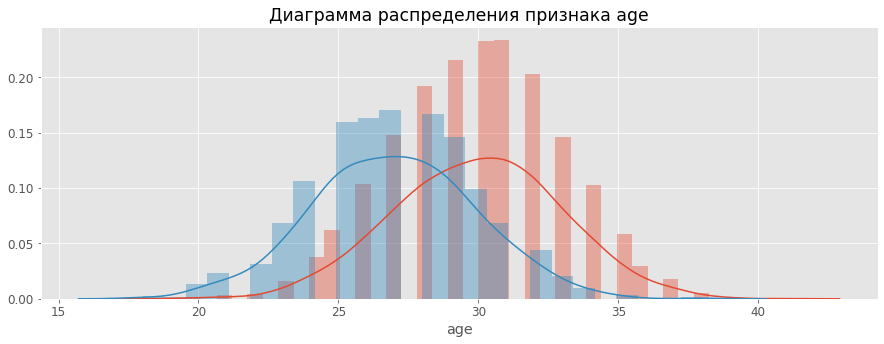

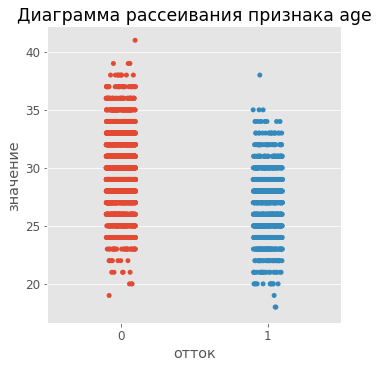

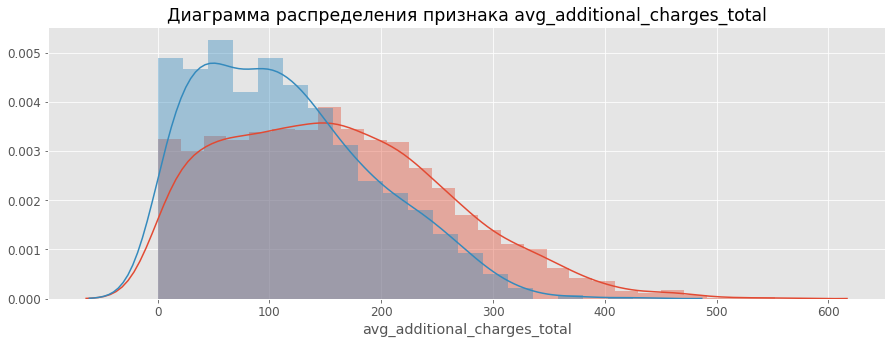

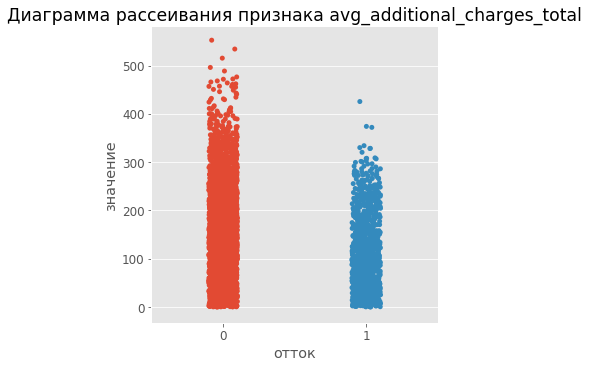

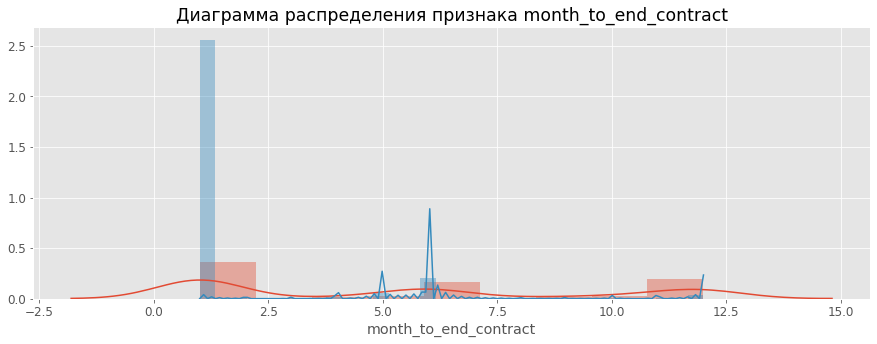

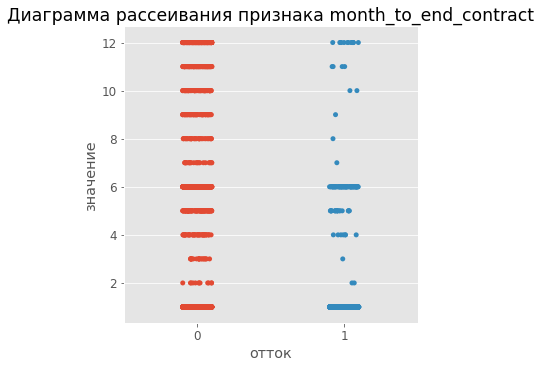

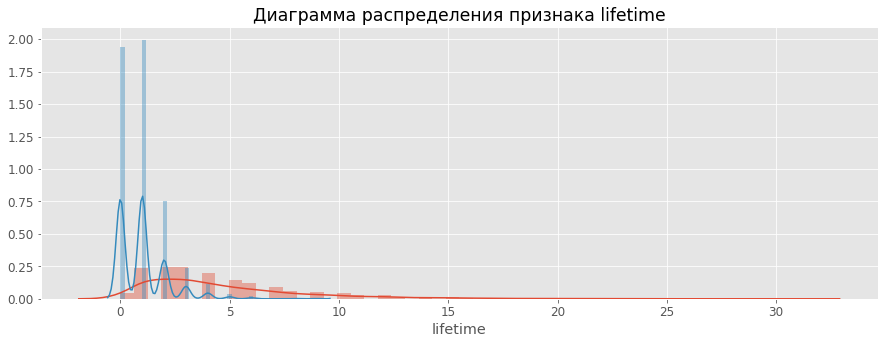

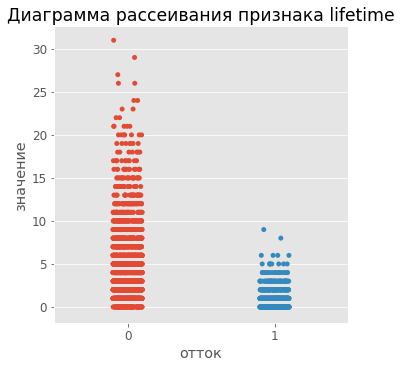

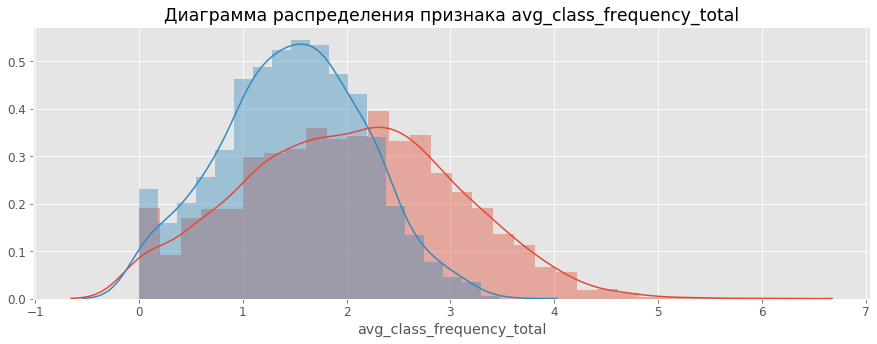

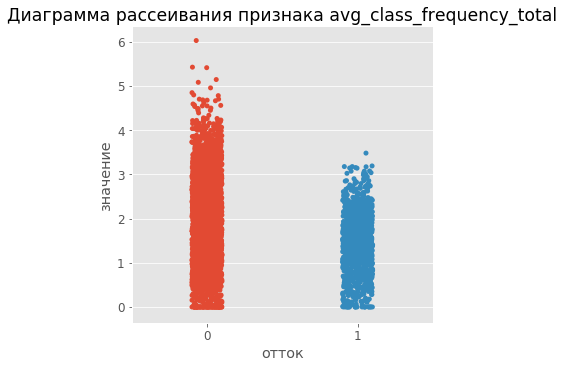

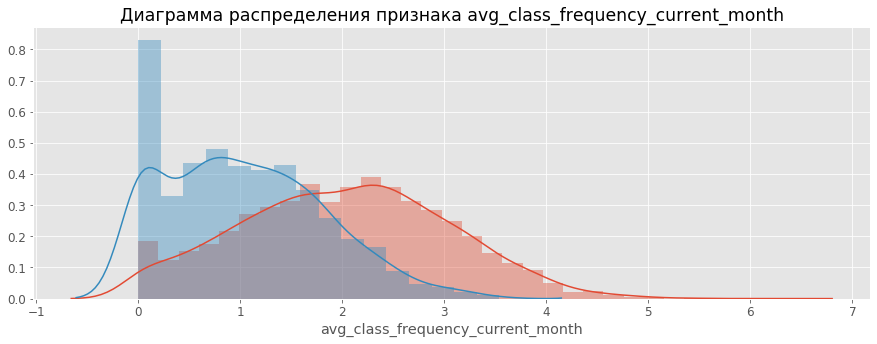

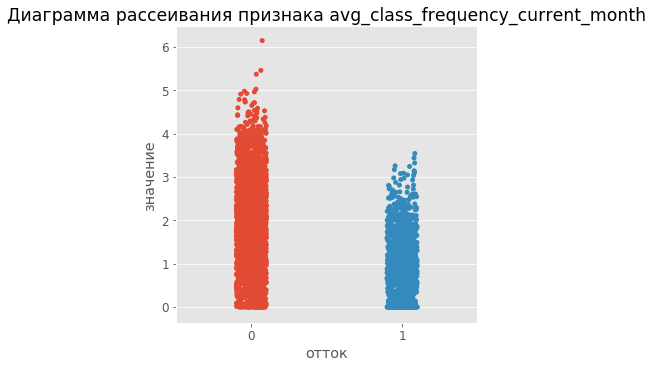

In [11]:
# построение диаграмм распределения количественных признаков по целевой переменной (оттоку)

for col in list_q: 
    sns.distplot(gch[gch['churn'] == 0][col])
    plt.title('Диаграмма распределения признака {}'.format(col))
    sns.distplot(gch[gch['churn'] == 1][col])
    sns.catplot(y=col, x="churn", data=gch)
    plt.title('Диаграмма рассеивания признака {}'.format(col))
    plt.xlabel('отток')
    plt.ylabel('значение')
    
    plt.show()

<p style="text-indent: 25px;">На основании проведённого EDA сформированы следующие первоначальные выводы.<p\>
<p style="text-indent: 25px;">1. К анализу предлагаются как категориальные, так и количественные признаки. Категориальные признаки имеют бинарные значения.<p>
<p style="text-indent: 25px;">2. Целевая переменная не имеет временной структуры.<p>
<p style="text-indent: 25px;">3. Мультиколлинеарность. Имеются две пары признаков с корреляцией более 0,9: длительность абонемента и срок до окончания абонимента, частота посещения в неделю за все время и частота посещения в неделю в последний месяц.<p>
<p style="text-indent: 25px;">4. На основании анализа характеристик средней и графиков распределения можно предположить, что наиболее влияющими на отток признаками являются: 
    
    - срок абонимента. Чаще уходят с абониментом сроком 1 месяц.
    - возраст. Чем моложе, тем чаще уходят, зона риска - 28 лет.
    - как долго клиент пользуется услугами, зона риска - 3 месяца
    - количество посещений. Зона риска - в среднем менее 2 посещений в неделю.

<p style="text-indent: 25px;">5. В количественных признаках имеются выбросы, при этом два количественных взаимосвязанных признака, длительность абонемента и срок до окончания абонимента, на основании визиуальной оценки графика имеют ненормальное распределение.<p>
<p style="text-indent: 25px;">6. Рассмотренные данные являются однородными, при первичном анализе в них прослеживается взаимосвязь, соответственно, они могут быть использованы для построения требуемой модели после обработки выбросов в количественных признаках.<p>

## 4. Модель прогнозирования оттока пользователей<a class="anchor" id="4-bullet"></a>

<p style="text-indent: 25px;">Обучитение модели будет произведено на train-выборке двумя способами: логистической регрессией и случайным лесом. Для оценки результата для обоих способов по валидационной выборке будут рассчитаны метрики  accuracy, precision и recall.<p>
<p style="text-indent: 25px;">С целью корректности данных в количественных признаках выбросы будут заменены на средние значения и проведена стандартизация. Выбросами в целях настоящего исследования принимаются значения превышающие 3 стандартных отклонения.<p>

In [12]:
# формирование списка признаков, имеющих нормальное распределение
list_n = ['age',
         'avg_additional_charges_total',
         'lifetime',
         'avg_class_frequency_total',
         'avg_class_frequency_current_month']

In [13]:
# удаление значений превышающих 3 стандартных отклонения

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return s.between(lower_limit, upper_limit)

for i in list_n: gch = gch[gch.groupby('churn')[i].apply(is_outlier)]

# оценка количества оставшихся анкет
gch.shape

(3909, 14)

In [14]:
# # функция замены выбросов
# def replace(group):
#     median, std = group.median(), group.std()
#     outliers = (group - median).abs() > 2*std
#     group[outliers] = median
#     return group

# # замена выбросов на средние значения и вывод новых значений для сравнения
# #gch[gch['churn']==0]['lifetime'] = gch[gch['churn']==0]['lifetime'].transform(replace)
# #gch[gch['churn']==1]['lifetime'] = gch[gch['churn']==1]['lifetime'].transform(replace)

# for col in list_q:
#     gch[col] = gch.groupby('churn')[col].transform(replace)

# gch.info()
# #gch['lifetime'].max()

<p style="text-indent: 25px;">После удаления выбросов количество оставшихся строк составило 3909 или 98%, что является приемлемой величиной.<p>

In [15]:
# отделение признаков от целевой переменной и разделение выборок на обучающую и тестовую
X = gch.drop('churn', axis=1)
y = gch['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# стандартизация обучающей выборки
scaler = StandardScaler()

X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [17]:
# обучение и расчёт метрик логистической регрессии и случайного леса

def make_prediction(m, X_train_st, y_train, X_test_st, y_test):
    model = m
    model.fit(X_train_st, y_train)
    predictions = model.predict(X_test_st)
    print('   Accuracy:{:.2f}; Precision:{:.2f}; Recall:{:.2f}.'.format(
                                                                  accuracy_score(y_test, predictions), 
                                                                  precision_score(y_test, predictions),
                                                                  recall_score(y_test, predictions)))
print('Значения метрик логистической регрессии')
make_prediction(LogisticRegression(), X_train_st, y_train, X_test_st, y_test)
print('Значения метрик случайного леса')
make_prediction(RandomForestClassifier(), X_train_st, y_train, X_test_st, y_test)

Значения метрик логистической регрессии
   Accuracy:0.91; Precision:0.85; Recall:0.83.
Значения метрик случайного леса
   Accuracy:0.91; Precision:0.88; Recall:0.77.


<p style="text-indent: 25px;">После сравнения метрик можно сделать вывод, что более точным оказался алгоритм логистической регрессии. Показатель полноты, т.е. доля выявленных реальных случаев, в этом алгоритме значительно больше.<p>

## 5. Кластеризация пользователей<a class="anchor" id="5-bullet"></a>

<p style="text-indent: 25px;">Будет произведено исследование данных с помощью методов иерархической агломеративной кластеризации и K-Means.<p>

In [18]:
# создание таблицы связи между признаками на основании ранее стандартизированной обучающей выборки

linked = linkage(X_train_st, method = 'ward')

In [19]:
# построение дендрограммы
# код закомментирован, график вставлен как изображениe для ускорения обработки блокнота

# dendrogram(linked, orientation='top')
# plt.show()

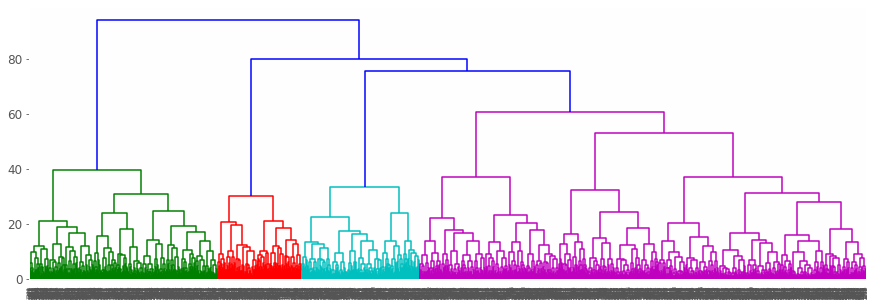

In [20]:
# формирование кластеров

km = KMeans(n_clusters = 5, random_state=0)

gch_st = scaler.fit_transform(gch)

labels = km.fit_predict(gch_st)

gch['cluster'] = labels

In [21]:
# доля оттока по кластерам
cl = round((gch.groupby('cluster')['churn'].sum()/gch.groupby('cluster')['churn'].count()*100), 2).to_frame()
cl.index += 1
cl.T

cluster,1,2,3,4,5
churn,25.47,0.48,0.0,1.49,100.0


<p style="text-indent: 25px;">Методом K-Means были сформированы кластеры, которые имеют ярко выраженную градацию относительно оттока. Можно выделить три группы. Кластер № 1 - значительное количество ушедших клиентов, кластер № 5 - состоит только из ушедших клиентов и кластеры №№ 2,3,4 - ушедшие клиенты практически отсутствуют. 

In [22]:
# оценка средних признаков, распределённых по кластерам
gch.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.528455,0.869919,0.466125,0.314363,0.000000,4.848238,0.430894,29.373984,145.298131,4.533875,3.710027,1.859781,1.733478,0.254743
1,0.551559,0.844125,0.369305,0.212230,0.998801,2.669065,0.440048,29.991607,157.129371,2.462830,4.586331,2.903247,2.910972,0.004796
2,0.473810,0.826190,0.463095,0.259524,1.000000,2.750000,0.375000,30.034524,151.579513,2.546429,4.188095,1.173415,1.171226,0.000000
3,0.504264,0.939232,0.773987,0.567164,1.000000,11.206823,0.555437,29.873134,161.571748,10.268657,4.470149,2.025093,2.020231,0.014925
4,0.509698,0.760776,0.341595,0.179957,0.996767,1.568966,0.257543,26.933190,114.265140,1.516164,0.943966,1.449734,1.028635,1.000000


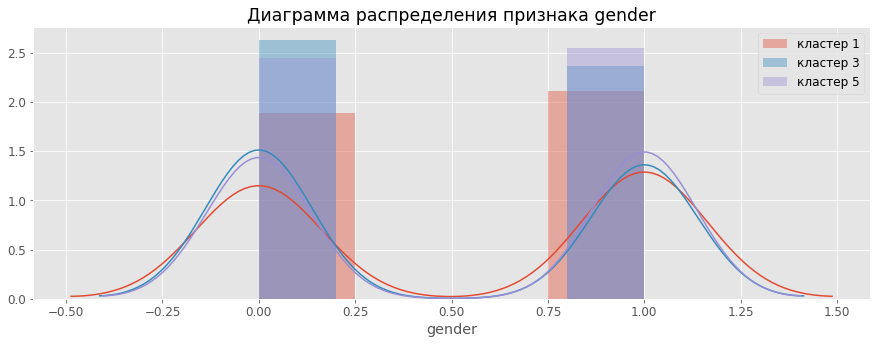

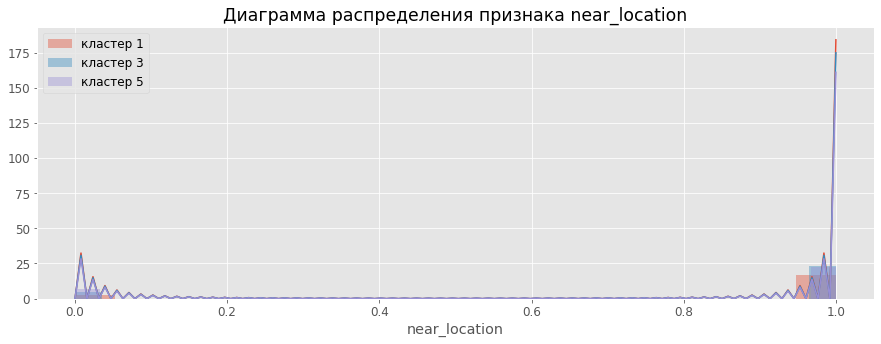

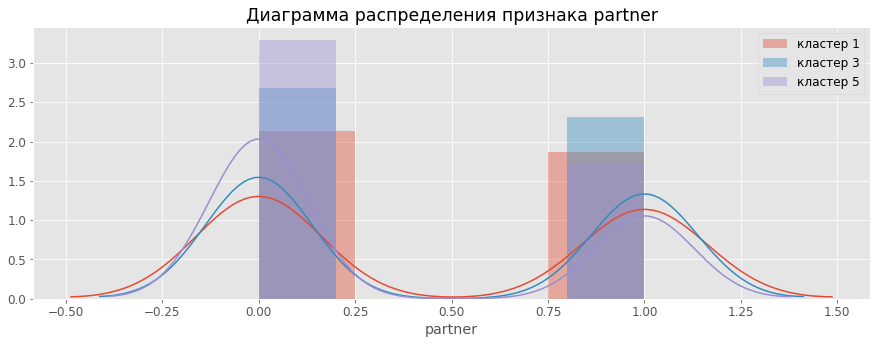

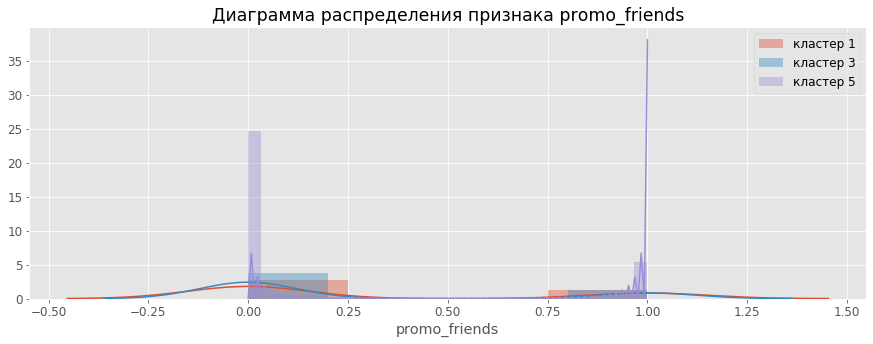

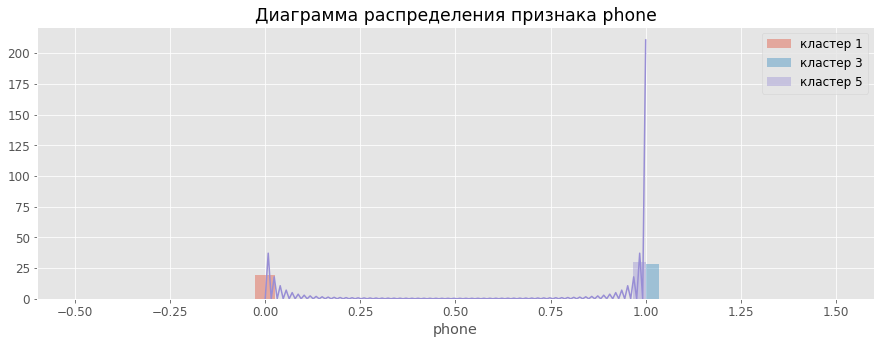

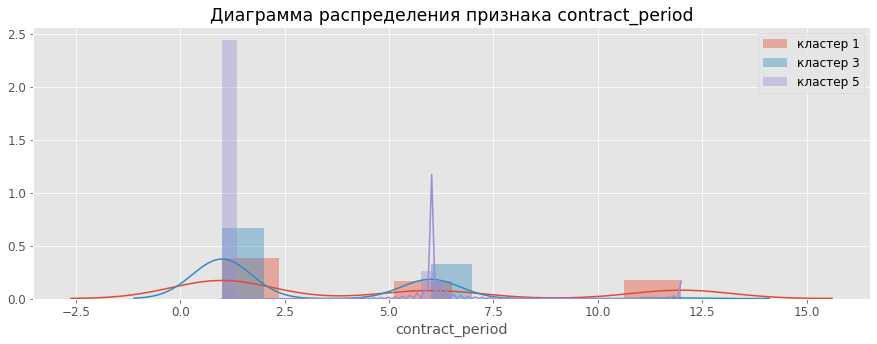

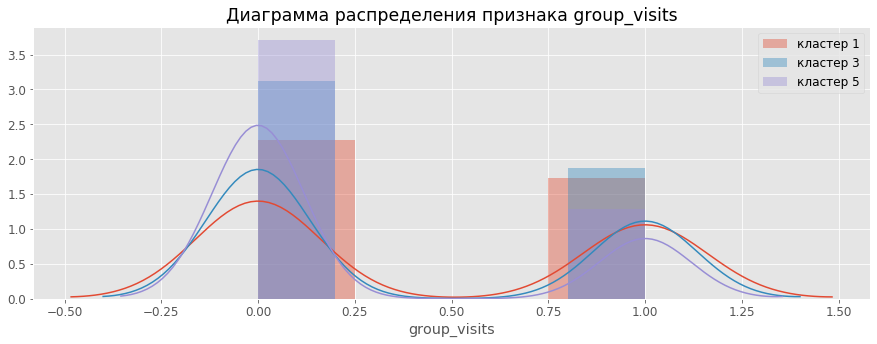

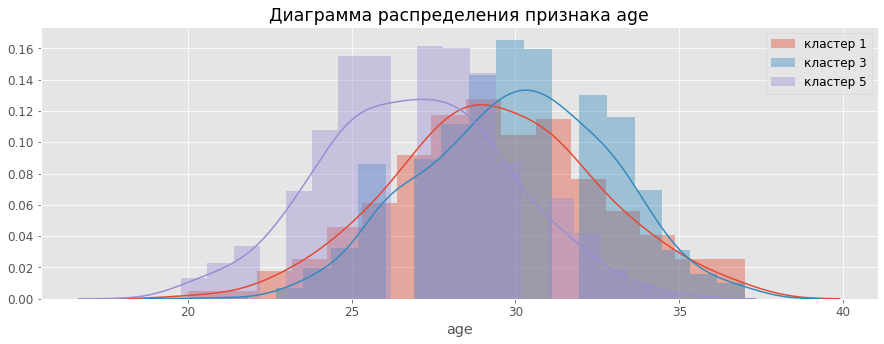

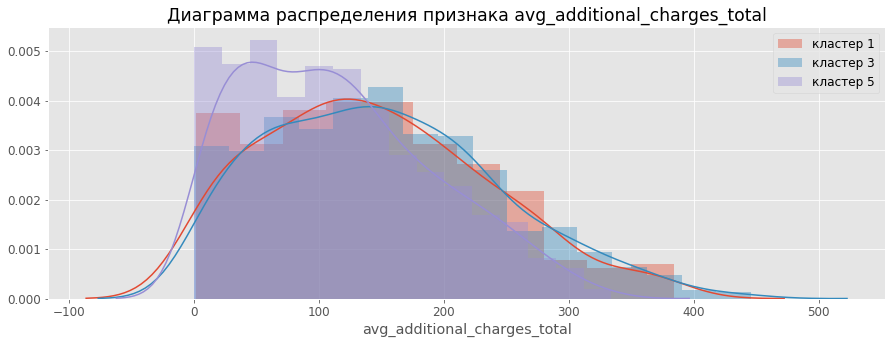

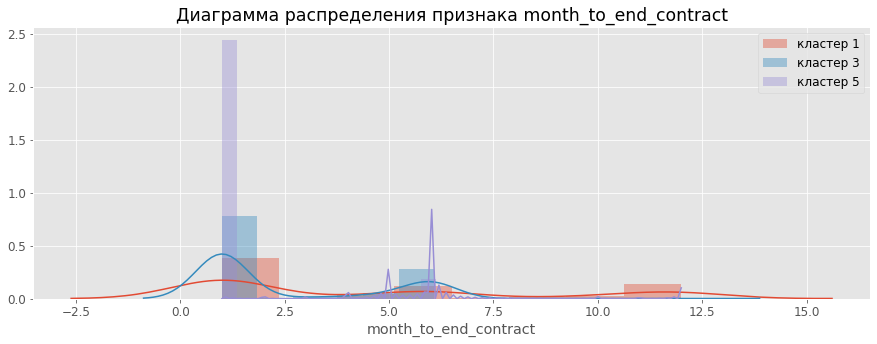

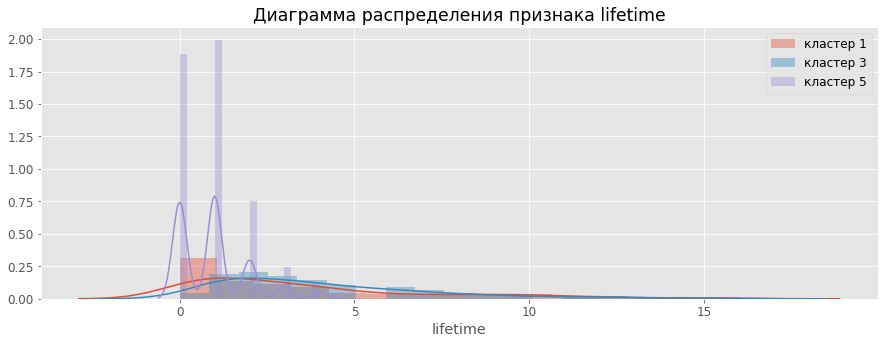

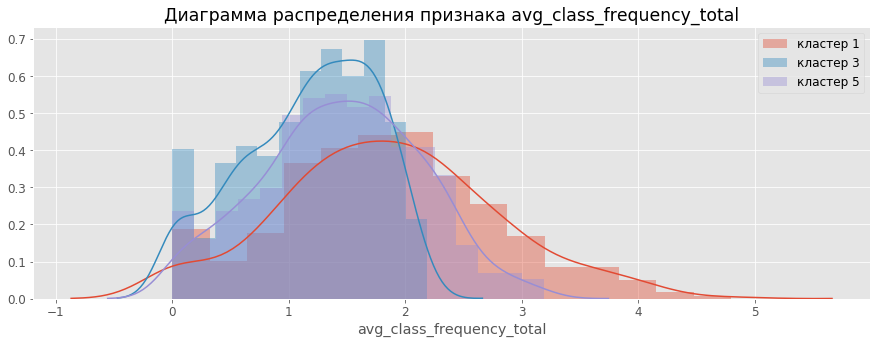

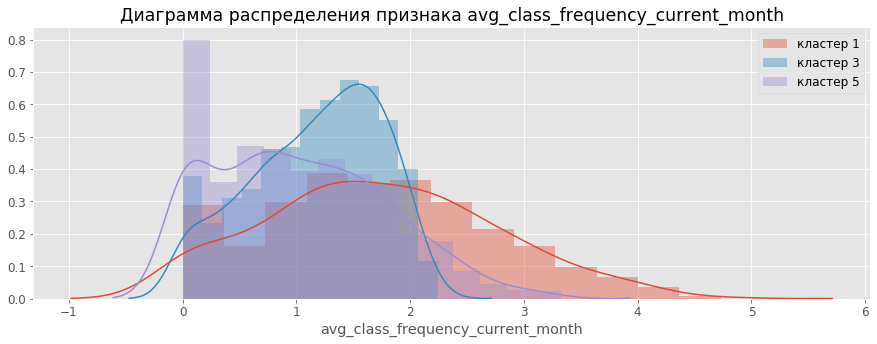

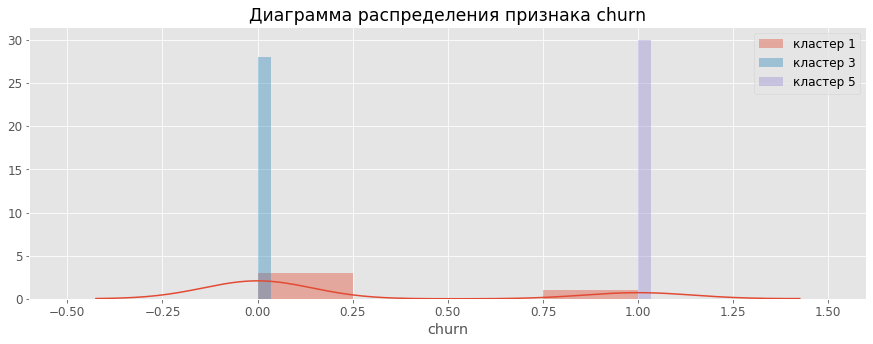

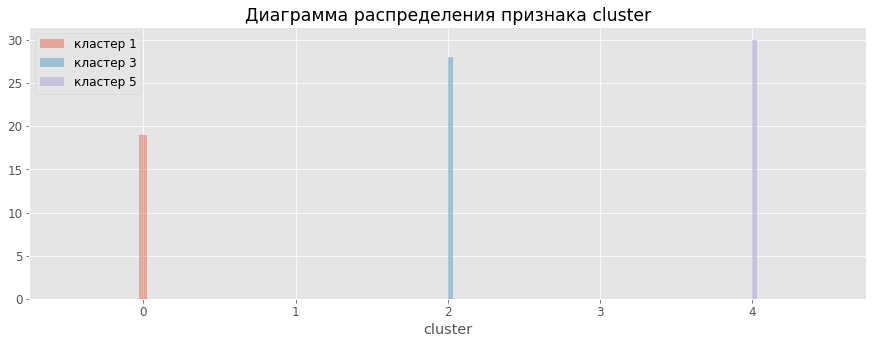

In [23]:
# построение распределения признаков в разрезе кластеров
# для улучшения визуализации из группы 
for col in gch.columns: 
    sns.distplot(gch[gch['cluster'] == 0][col], label='кластер 1')
    sns.distplot(gch[gch['cluster'] == 2][col], label='кластер 3')
    sns.distplot(gch[gch['cluster'] == 4][col], label='кластер 5')
    plt.title('Диаграмма распределения признака {}'.format(col))
    plt.legend()
    plt.show()

<p style="text-indent: 25px;"> Анализ средних значений признаков, сгруппированных по кластерам, и распределений признаков позволяет выявить следующие особенности ушедших клиентов:
    
    - среди них менее всего проживавших в районе, где находится фитнес-центр,
    - среди них меньше всего сотрудников компаний-партнеров,
    - они менее всего участвовали в акции "приведи друга",
    - они чаще всего покупали абонименты на 1 месяц,
    - меньше участвовали в групповых занятиях,
    - они более молоды, средний возраст 27 лет против 30 лет среди лояльных клиентов,
    - их средние дополнительные расходы значительно меньше лояльных клиентов и составляют не более 115 рублей,
    - они за последний месяц в среднем посещали зал около 1 раза в неделю или 1,5 занятия за весь период абонимента,
    - чаще всего прекращение посещения происходит на первом месяце действия абонимента.
</p>

## 6. Выводы и рекомендации<a class="anchor" id="6-bullet"></a>

*Выводы*
<p style="text-indent: 25px;"> В ходе исследования был создана модель прогнозирования прекращения посещения фитнес-центра клиентами и проведена кластеризация клиентов для определения их профиля. </p>
<p style="text-indent: 25px;">Значения метрик разработанной модели бинарной классификации пользователей

    
   Логистической регрессии - Accuracy:0.91; Precision:0.85; Recall:0.83.<br>
   Случайного леса - Accuracy:0.90; Precision:0.87; Recall:0.75.
</p>
<p style="text-indent: 25px;">Значения метрик позволяют утверждать об успешности применения модели.</p>
<p style="text-indent: 25px;">С помощью метода K-Means был разработан риск-профиль клиента. К оттоку склонны следующие категории клиентов:
    
    - не проживающие в районе, где находится фитнес-центр,
    - не сотрудник компании-партнера,
    - не участвующие в акции "приведи друга",
    - покупающие абонементы на 1 месяц,
    - не участвующие в групповых занятиях,
    - до 27 лет,
    - тратят на доп. услуги не более 115 рублей,
    - посещающие занятия в среднем не более 1,5 раз в неделю,
    - риск прекращения занятий выше всего на первом месяце занятий.
</p>

*Рекомендации*
<p style="text-indent: 25px;">Проводить адресную коммуникацию в первый месяц после покупки абонeмента с клиентами из группы риска.</p>
<p style="text-indent: 25px;">Разработать групповые программы с ориентацией на приоритеты клиентов моложе 27 лет.</p>
<p style="text-indent: 25px;">Провести реферальную акцию с акцентом на приоритеты клиентов моложе 27 лет с условием приобретения абонемента сроком более 1 месяца.</p>
<p style="text-indent: 25px;">В качестве пилотного проекта предложить возможность приобретать абонементы со сроком 2 и 3 месяца.</p>
<p style="text-indent: 25px;">Пересмотреть плейлист.</p>
<br>